In [1]:
import math                      # providing access to the mathematical functions defined by the C standard
import matplotlib.pyplot as plt  # plotting library
import scipy                     # scientific computnig and technical computing
import cv2                       # working with, mainly resizing, images
import numpy as np               # dealing with arrays
import glob                      # return a possibly-empty list of path names that match pathname
import os                        # dealing with directories
import pandas as pd              # providing data structures and data analysis tools
import tensorflow as tf       
import itertools
import random
from random import shuffle       # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm            # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion
from PIL import Image
from scipy import ndimage
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from skimage import io
from sklearn import metrics
%matplotlib inline
np.random.seed(1)

import keras as k
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [2]:
base_dir = os.getcwd()+"\\"

In [3]:
training_img = io.imread('images_training.tiff')
training_imgarray = np.array(training_img)

In [ ]:
'''validation_img = io.imread('images_test.tiff')
validation_imgarray = np.array(validation_img)'''

In [ ]:
'''
df = pd.read_csv('descriptions_training.csv', header=None)
df = df.drop(columns=[2,3,4,5])
df = df.rename(columns={0:"img",1:"label"})

for i, row in df.iterrows():
    image_array = training_imgarray[i]
    if row[1] == 0:
        scipy.misc.toimage(image_array, cmin=0.0, cmax=...).save(base_dir+"\\train\\0\\"+str(i)+'.jpg')
    elif row[1] == 1:
        scipy.misc.toimage(image_array, cmin=0.0, cmax=...).save(base_dir+"\\train\\1\\"+str(i)+'.jpg')
    else:
        scipy.misc.toimage(image_array, cmin=0.0, cmax=...).save(base_dir+"\\train\\2\\"+str(i)+'.jpg')
'''        

In [ ]:
'''
# Creating one-hot labels
labels = df.label
labels = np.array(labels)
labels = labels.reshape(df.shape[0],1)
labels = k.utils.to_categorical(labels, num_classes=3)
'''

In [20]:
# Hyperparameters for creating training and validation dataset
batch_size = 2048
seed = 1729

# Training generator
train_dir = base_dir+"\\train\\"
train_datagen = ImageDataGenerator(
                                rescale=1./255,
                                fill_mode='nearest',
                                validation_split=0.2) # set validation split
train_data = train_datagen.flow_from_directory(
                                            train_dir, 
                                            target_size=(24, 24),
                                            batch_size=batch_size,
                                            seed=seed,
                                            shuffle=True,
                                            class_mode='categorical',
                                            subset='training') # set as training data
test_data = train_datagen.flow_from_directory(
                                            train_dir, # same directory as training data
                                            target_size=(24, 24),
                                            batch_size=batch_size,
                                            seed=seed,
                                            shuffle=True,
                                            class_mode='categorical',
                                            subset='validation') # set as validation data

train_num = train_data.samples
validation_num = test_data.samples 

Found 167948 images belonging to 3 classes.
Found 41985 images belonging to 3 classes.


In [22]:
# Model Hyperparameters
LR = 1e-3
channels=3
seed=1729
batch_size = 2048
num_classes = 3
epochs = 100
data_augmentation = True
num_predictions = 100


# Model Definition
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(24, 24, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 22, 22, 16)        448       
_________________________________________________________________
activation_37 (Activation)   (None, 22, 22, 16)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 9, 9, 16)          2320      
_________________________________________________________________
activation_38 (Activation)   (None, 9, 9, 16)          0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 4, 4, 32)          4640      
__________

In [24]:
# Start training

filepath=str(base_dir+"\\model.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint]#, stopper]

history = model.fit_generator(train_data,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=test_data,
                              validation_steps= validation_num // batch_size,
                              callbacks=callbacks_list, 
                              verbose = 2
                             )

Epoch 1/100
 - 103s - loss: 0.7361 - acc: 0.6105 - val_loss: 0.4082 - val_acc: 0.8994

Epoch 00001: val_acc improved from -inf to 0.89939, saving model to C:\Users\Suryam Sharma\Shivam\\model.h5f
Epoch 2/100
 - 93s - loss: 0.4391 - acc: 0.8450 - val_loss: 0.2851 - val_acc: 0.9122

Epoch 00002: val_acc improved from 0.89939 to 0.91221, saving model to C:\Users\Suryam Sharma\Shivam\\model.h5f
Epoch 3/100
 - 98s - loss: 0.2849 - acc: 0.8948 - val_loss: 0.2221 - val_acc: 0.9204

Epoch 00003: val_acc improved from 0.91221 to 0.92037, saving model to C:\Users\Suryam Sharma\Shivam\\model.h5f
Epoch 4/100
 - 95s - loss: 0.2242 - acc: 0.9156 - val_loss: 0.2427 - val_acc: 0.9178

Epoch 00004: val_acc did not improve from 0.92037
Epoch 5/100
 - 94s - loss: 0.1981 - acc: 0.9245 - val_loss: 0.1958 - val_acc: 0.9328

Epoch 00005: val_acc improved from 0.92037 to 0.93277, saving model to C:\Users\Suryam Sharma\Shivam\\model.h5f
Epoch 6/100
 - 103s - loss: 0.1829 - acc: 0.9296 - val_loss: 0.1646 - val_

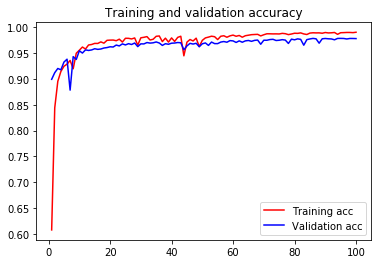

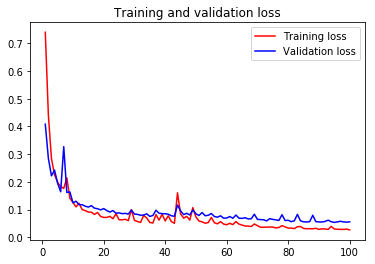

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()